In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Paths to directories

In [2]:
# Paths
# -----
# Core data directory used to initialise and construct DCOPF model
data_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data')

# Directory containing representative operating conditions for each week
scenarios_dir = os.path.join(os.path.curdir, os.path.pardir, '1_create_scenarios', 'output')

# DCOPF model output results directory
results_dir = os.path.join(os.path.curdir, os.path.pardir, '2_updating_strategy', 'modules', 'output')

### Model parameter summary information

In [3]:
def get_all_run_summaries(results_dir):
    "Collate information summarising the parameters used in each run"
    
    # Find all results summary files
    run_summary_files = [i for i in os.listdir(results_dir) if 'run_summary' in i]

    # Container for dictionaries summarising model runs
    run_summaries = dict()

    for i in run_summary_files:
        with open(os.path.join(results_dir, i), 'rb') as f:
            run_summary = pickle.load(f)
            run_summaries = {**run_summaries, **run_summary}
            
    return run_summaries

# Summary of parameters used for each run
run_summaries = pd.DataFrame.from_dict(get_all_run_summaries(results_dir), orient='index')
run_summaries

,shock_option,update_mode,update_gain,week_of_shock,target_scheme_revenue,initial_permit_price,initial_baseline,initial_rolling_scheme_revenue,seed
0EBCAD13,EMISSIONS_INTENSITY_SHOCK,NO_UPDATE,1,10,0,40,1,0,10
17C2D2A8,GENERATION_SHOCK,HOOKE_UPDATE,1,10,0,40,1,0,10
593BE533,NO_SHOCKS,NO_UPDATE,1,10,0,40,1,0,10
616C9C83,NO_SHOCKS,HOOKE_UPDATE,1,10,0,40,1,0,10
6A001F83,NO_SHOCKS,HISTORIC_UPDATE,1,10,0,40,1,0,10
8032B6AA,NO_SHOCKS,NO_UPDATE,1,10,0,0,0,0,10
AB464AE3,EMISSIONS_INTENSITY_SHOCK,HOOKE_UPDATE,1,10,0,40,1,0,10
B2A92B8A,GENERATION_SHOCK,HISTORIC_UPDATE,1,10,0,40,1,0,10
BE3477E0,GENERATION_SHOCK,NO_UPDATE,1,10,0,40,1,0,10
C02E2453,EMISSIONS_INTENSITY_SHOCK,HISTORIC_UPDATE,1,10,0,40,1,0,10


Parse results for a given scenario
* Total emissions for each NEM region and nation
* Total scheme revenue for each NEM region and nation
* Generation by fuel type and NEM region and nation

Then aggregate scenarios into weekly values
* Average price for each NEM region
* Emissions intensity for system and regulated generators, for nation and each NEM region
* Generation by fuel type and NEM region and nation

In [4]:
# ID of run number for which results should be obtained
run_id = 'AB464AE3'

# Network nodes
df_n = pd.read_csv(os.path.join(data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_nodes.csv'), index_col='NODE_ID')

# Representative operating scenarios for each week
with open(os.path.join(scenarios_dir, 'weekly_scenarios.pickle'), 'rb') as f:
    df_s = pickle.load(f)

# Power output from each scenario - from DCOPF model
with open(os.path.join(results_dir, f'{run_id}_scenario_power_output.pickle'), 'rb') as f:
    scenario_power_output = pickle.load(f)
    
# Generator parameters used in model
with open(os.path.join(results_dir, f'{run_id}_generators.pickle'), 'rb') as f:
    df_g = pickle.load(f)
    
# Baseline for each week
with open(os.path.join(results_dir, f'{run_id}_week_baseline.pickle'), 'rb') as f:
    week_baseline = pickle.load(f)
    
# Rolling scheme revenue for each week
with open(os.path.join(results_dir, f'{run_id}_week_rolling_scheme_revenue.pickle'), 'rb') as f:
    week_rolling_scheme_revenue = pickle.load(f)

# Emissions intensity shock factor
with open(os.path.join(results_dir, f'{run_id}_emissions_intensity_shock_factor.pickle'), 'rb') as f:
    df_emissions_shock_factor = pickle.load(f)
    
    
# Generator output results
# ------------------------
# Power output from each generator for each time period
df = pd.DataFrame(scenario_power_output)

# Re-organise DataFrame so multi-index is removed, with individual columns containing week and scenario indices
df_o = df.reset_index().melt(id_vars=['index']).rename(columns={'index': 'DUID', 'variable_0': 'week_index', 'variable_1': 'scenario_index', 'value': 'power_pu'}).astype({'week_index': int, 'scenario_index': int})

# Duration for each scenario
df_scenario_duration = df_s.loc[('hours', 'duration')]
df_scenario_duration.name = 'duration_hrs'
df_scenario_duration = df_scenario_duration.reset_index()

# Merge scenario duration information
df_o = pd.merge(df_o, df_scenario_duration, how='left', left_on=['week_index', 'scenario_index'], right_on=['week', 'scenario'])

# Get emissions, NEM region, and fuel type for each DUID
df_o = pd.merge(df_o, df_g[['EMISSIONS', 'NEM_REGION', 'FUEL_TYPE']], how='left', left_on='DUID', right_index=True)

# Total energy output for each DUID and each scenario
df_o['energy_MWh'] = df_o['power_pu'].mul(100).mul(df_o['duration_hrs'])

# Emissions intensities change after week_of_shock if 'EMISSIONS_INTENSITY_SHOCK' imposed
df_o['EMISSIONS_SHOCK'] = df_o.apply(lambda x: x['EMISSIONS'] if x['week_index'] < run_summaries.loc[run_id, 'week_of_shock'] else df_emissions_shock_factor.loc[x['DUID']] * x['EMISSIONS'], axis=1)

# Total emissions for each DUID and each scenario
if run_summaries.loc[run_id, 'shock_option'] == 'EMISSIONS_INTENSITY_SHOCK':
    df_o['emissions_tCO2'] = df_o['energy_MWh'].mul(df_o['EMISSIONS_SHOCK'])
else:
    df_o['emissions_tCO2'] = df_o['energy_MWh'].mul(df_o['EMISSIONS'])


# Aggregated fixed injection information
# --------------------------------------
# Fixed nodal injections and withdrawals (demand, hydro, and intermittent sources)
df_fixed = df_s.drop(('hours', 'duration')).reset_index().melt(id_vars=['level', 'NODE_ID']).rename(columns={'value': 'power_MW'}).astype({'NODE_ID': int, 'week': int, 'scenario': int})

# Merge duration for each operating scenario
df_fixed = pd.merge(df_fixed, df_scenario_duration, how='left', left_on=['week', 'scenario'], right_on=['week', 'scenario'])

# Compute total energy injection / withdrawal
df_fixed['energy_MWh'] = df_fixed['power_MW'].mul(df_fixed['duration_hrs'])

# Merge NEM region IDs
df_fixed = pd.merge(df_fixed, df_n[['NEM_REGION']], how='left', left_on='NODE_ID', right_index=True)

# Aggregate fixed injections for each NEM region
df_regional_fixed = df_fixed.groupby(['NEM_REGION', 'week', 'level'])[['energy_MWh']].sum().reset_index()

# Aggregate fixed injections for whole nation
df_national_fixed = df_regional_fixed.groupby(['week', 'level'])[['energy_MWh']].sum().reset_index()
df_national_fixed['NEM_REGION'] = 'NATIONAL'

# Combine regional and national level statistics
df_combined_fixed = pd.concat([df_regional_fixed, df_national_fixed], sort=False).rename(columns={'week': 'week_index'}).set_index(['level', 'NEM_REGION', 'week_index']).sort_index()


# Weekly regional and national statistics
# ---------------------------------------
# Total energy output and emissions from regulated generators for each NEM region
df_regional_stats = df_o.groupby(['week_index', 'NEM_REGION'])[['energy_MWh', 'emissions_tCO2']].sum().reset_index()

# Total energy output and emissions from regulated generators for nation
df_national_stats = df_regional_stats.groupby('week_index')[['energy_MWh', 'emissions_tCO2']].sum().reset_index()
df_national_stats['NEM_REGION'] = 'NATIONAL'

# Combined regional and national level statistics
df_combined_stats = pd.concat([df_regional_stats, df_national_stats], sort=False).set_index(['NEM_REGION', 'week_index']).sort_index()

# Average emissions intensity of regulated generators
df_combined_stats['average_regulated_emissions_intensity'] = df_combined_stats['emissions_tCO2'].div(df_combined_stats['energy_MWh'])

# Energy demand each period
df_combined_stats = pd.merge(df_combined_stats, df_combined_fixed.loc['demand'].reset_index().rename(columns={'energy_MWh': 'demand_MWh'}), how='left', left_index=True, right_on=['NEM_REGION', 'week_index'])

# Fixed energy injections from hydro sources
df_combined_stats = pd.merge(df_combined_stats, df_combined_fixed.loc['hydro'].reset_index().rename(columns={'energy_MWh': 'hydro_MWh'}), how='left', left_on=['NEM_REGION', 'week_index'], right_on=['NEM_REGION', 'week_index'])

# Fixed energy injections from intermittent generators
df_combined_stats = pd.merge(df_combined_stats, df_combined_fixed.loc['intermittent'].reset_index().rename(columns={'energy_MWh': 'intermittent_MWh'}), how='left', left_on=['NEM_REGION', 'week_index'], right_on=['NEM_REGION', 'week_index']).set_index(['NEM_REGION', 'week_index'])

# Check national energy demand and energy injections balance
df_combined_stats['energy_MWh'].add(df_combined_stats['hydro_MWh']).add(df_combined_stats['intermittent_MWh']).subtract(df_combined_stats['demand_MWh']).loc['NATIONAL']

# Average system emissions intensity (total emissions / total demand)
df_combined_stats['average_system_emissions_intensity'] = df_combined_stats['emissions_tCO2'].div(df_combined_stats['demand_MWh'])

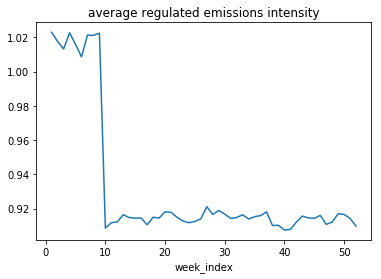

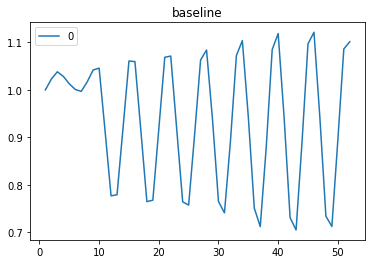

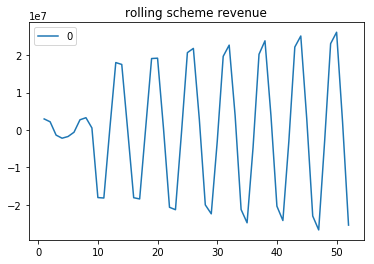

In [5]:
plt.clf()

# Average weekly emissions intensities of regulated generators
df_combined_stats.loc['NATIONAL', 'average_regulated_emissions_intensity'].plot(title='average regulated emissions intensity')

# Emissions intensity baseline applying to each week, using the updating strategy implemented when running the model
pd.DataFrame.from_dict(week_baseline, orient='index').plot(title='baseline')

# Rolling scheme revenue - calculated when running model
pd.DataFrame.from_dict(week_rolling_scheme_revenue, orient='index').plot(title='rolling scheme revenue')

plt.show()

In [6]:
def get_weekly_statistics(df_o, week_index, baseline, permit_price, emissions_shock=False):
    "Compute net scheme revenue for a given week"

    # Extract generator output data for the week under investigation
    df_wk = df_o.loc[df_o['week_index']==week_index].copy()

    # Compute net scheme revenue given baseline that applied for that week
    if emissions_shock:
        df_wk['net_scheme_revenue'] = df_wk['EMISSIONS_SHOCK'].subtract(baseline).mul(df_wk['energy_MWh']).mul(permit_price)
    else:
        df_wk['net_scheme_revenue'] = df_wk['EMISSIONS'].subtract(baseline).mul(df_wk['energy_MWh']).mul(permit_price)
    
    return df_wk[['energy_MWh', 'net_scheme_revenue', 'emissions_tCO2']].sum().to_dict()

In [140]:
from pyomo.environ import *

def mpc_baseline_update(df_o, week_index, forecast_interval, permit_price, initial_rolling_scheme_revenue, target_rolling_scheme_revenue, initial_emissions_intensity_baseline, emissions_shock):
    "Compute baseline path using model predictive control"
    
    # Initialise model object
    model = ConcreteModel()

    # Predicted emissions intensity
    predicted_energy = df_o.groupby(['DUID', 'week_index'])['energy_MWh'].sum()

    # Predicted emissions intensity for regulated generators
    if emissions_shock:
        predicted_emissions_intensities = df_o.groupby(['DUID', 'week_index'])['EMISSIONS_SHOCK'].mean()
    else:
        predicted_emissions_intensities = df_o.groupby(['DUID', 'week_index'])['EMISSIONS'].mean()


    # Sets
    # ----
    # Generators
    model.OMEGA_G = Set(initialize=df_o['DUID'].unique())

    # Time index
    model.OMEGA_T = Set(initialize=range(week_index, week_index+forecast_interval+1), ordered=True)


    # Parameters
    # ----------
    # Predicted generator emissions intensity for future periods
    def EMISSIONS_PRED_RULE(model, g, t):
        return float(predicted_emissions_intensities.loc[(g, t)] * np.random.uniform(0.9, 1.1))
    model.EMISSIONS_PRED = Param(model.OMEGA_G, model.OMEGA_T, rule=EMISSIONS_PRED_RULE, mutable=True)

    # Predicted weekly energy output
    def ENERGY_PRED_RULE(model, g, t):
        return float(predicted_energy.loc[(g, t)] * np.random.uniform(0.9, 1.1))
    model.ENERGY_PRED = Param(model.OMEGA_G, model.OMEGA_T, rule=ENERGY_PRED_RULE, mutable=True)

    # Permit price
    model.PERMIT_PRICE = Param(initialize=permit_price, mutable=True)

    # Initial rolling scheme revenue
    model.INITIAL_ROLLING_SCHEME_REVENUE = Param(initialize=initial_rolling_scheme_revenue, mutable=True)

    # Emissions intensity baseline from previous period
    model.INITIAL_EMISSIONS_INTENSITY_BASELINE = Param(initialize=initial_emissions_intensity_baseline, mutable=True)

    # Rolling scheme revenue target at end of finite horizon
    model.TARGET_ROLLING_SCHEME_REVENUE = Param(initialize=target_rolling_scheme_revenue, mutable=True)
    
    
    # Variables
    # ---------
    # Emissions intensity baseline
    model.phi = Var(model.OMEGA_T)


    # Constraints
    # -----------
    # Scheme revenue must be 0 at end of model horizon
    model.SCHEME_REVENUE = Constraint(expr=model.INITIAL_ROLLING_SCHEME_REVENUE + sum((model.EMISSIONS_PRED[g, t] - model.phi[t]) * model.ENERGY_PRED[g, t] * model.PERMIT_PRICE for g in model.OMEGA_G for t in model.OMEGA_T) == 0)

    # Baseline must be non-negative
    def BASELINE_NONNEGATIVE_RULE(model, t):
        return model.phi[t] >= 0
    model.BASELINE_NONNEGATIVE = Constraint(model.OMEGA_T, rule=BASELINE_NONNEGATIVE_RULE)

    # Objective function
    # ------------------
    # Minimise changes to baseline over finite time horizon
    model.OBJECTIVE = Objective(expr=(sum( (model.phi[t] - model.phi[t-1]) * (model.phi[t] - model.phi[t-1]) 
                                          for t in model.OMEGA_T if t > model.OMEGA_T.first()) 
                                      + ((model.phi[model.OMEGA_T.first()] - model.INITIAL_EMISSIONS_INTENSITY_BASELINE) * (model.phi[model.OMEGA_T.first()] - model.INITIAL_EMISSIONS_INTENSITY_BASELINE)))
                               )

    # Solve model
    opt = SolverFactory('gurobi', solver_io='lp')
    opt.solve(model)

    # Return forecast baselines
    return OrderedDict(model.phi.get_values())

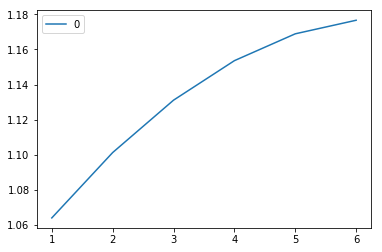

In [114]:
plt.clf()
pd.DataFrame.from_dict(baseline_path, orient='index').plot()
plt.show()

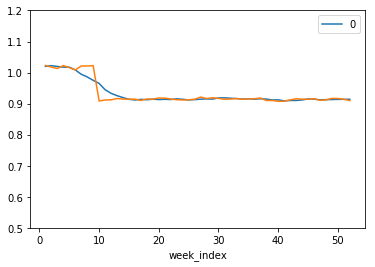

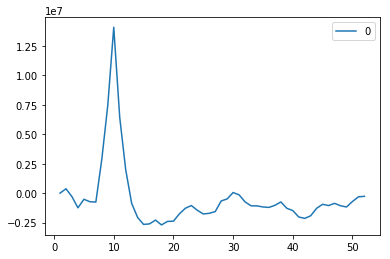

In [149]:
week_index = 1
baseline = 1.02
target_scheme_revenue = 0
rolling_scheme_revenue = 0
permit_price = run_summaries.loc[run_id, 'initial_permit_price']
update_gain = 0.7
forecast_interval=5

weekly_baseline = dict()
weekly_rolling_scheme_revenue = dict()

for week_index in range(1, 53):
    # Record baseline at start of week
    weekly_baseline[week_index] = baseline
    
    # Record rolling scheme revenue at start of week
    weekly_rolling_scheme_revenue[week_index] = rolling_scheme_revenue
    
    # Perform computations for the given week
    current_week_statistics = get_weekly_statistics(df_o=df_o, week_index=week_index, baseline=baseline, permit_price=permit_price, emissions_shock=True)    
    
    # Rolling scheme revenue
    rolling_scheme_revenue += current_week_statistics['net_scheme_revenue']
    
    # Computation for the next week
    if week_index < 52:
        next_week_statistics = get_weekly_statistics(df_o=df_o, week_index=week_index+1, baseline=baseline, permit_price=40, emissions_shock=True)
    
        # Total output next week
        next_week_regulated_energy = next_week_statistics['energy_MWh']
    
        # Next week regulated emissions intensity
        next_week_regulated_emissions_intensity = next_week_statistics['emissions_tCO2'] / next_week_statistics['energy_MWh']
        
    # Historic update
#     baseline = (next_week_regulated_emissions_intensity) - update_gain * ((target_scheme_revenue - rolling_scheme_revenue) / (permit_price * (next_week_regulated_energy)))
#     baseline = (current_week_statistics['emissions_tCO2'] / current_week_statistics['energy_MWh']) - update_gain * ((target_scheme_revenue - rolling_scheme_revenue) / (permit_price * (current_week_statistics['energy_MWh'])))

    # Hooke update
#     baseline += - update_gain * ((target_scheme_revenue - rolling_scheme_revenue) / (permit_price * next_week_regulated_energy))
#     baseline += - update_gain * ((target_scheme_revenue - rolling_scheme_revenue) / (permit_price * current_week_statistics['energy_MWh']))

    # MPDC update - Implement MPC to forecast optimal baseline path to rebalance scheme revenue
    if week_index <= 52 - forecast_interval:
        baseline_path = mpc_baseline_update(df_o=df_o, week_index=week_index, forecast_interval=forecast_interval, permit_price=40, initial_rolling_scheme_revenue=rolling_scheme_revenue, target_rolling_scheme_revenue=0, initial_emissions_intensity_baseline=baseline, emissions_shock=True)
    baseline = baseline_path[week_index]

    # Set baseline equal to zero if update results in a negative value
    if baseline < 0:
        baseline = 0


plt.clf()
ax = pd.DataFrame.from_dict(weekly_baseline, orient='index').plot()
df_combined_stats.loc['NATIONAL', 'average_regulated_emissions_intensity'].plot(ax=ax)
ax.set_ylim([0.5, 1.2])
plt.show()

plt.clf()
ax = pd.DataFrame.from_dict(weekly_rolling_scheme_revenue, orient='index').plot()
plt.show()